# R4 on DECOY DERMA MNIST

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
from models.R4_models import DermaNet
from models.robust_regularizer import input_gradient_interval_regularizer
from models.pipeline import (train_model_with_pgd_robust_input_grad, train_model_with_certified_input_grad, load_params_or_results_from_file,
                             test_model_accuracy, test_delta_input_robustness, write_results_to_file, uniformize_magnitudes_schedule)
from datasets import derma_mnist

# Get the dataloaders 

In [ ]:
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)
batch_size = 256
IMG_SIZE = 64

cuda:0


In [3]:
train_dset = derma_mnist.DecoyDermaMNIST(True, size=IMG_SIZE)
test_dset = derma_mnist.DecoyDermaMNIST(False, size=IMG_SIZE)
print(len(train_dset), len(test_dset))
print(f"test masks shape: {train_dset.dset_masks.shape}")
print(f"test images shape: {test_dset.dset_inputs.shape}")
print(f"num 0 labels: {torch.sum(train_dset.dset_labels == 0)}")
print(f"num 1 labels: {torch.sum(train_dset.dset_labels == 1)}")
print(f"num 1 labels test: {torch.sum(test_dset.dset_labels == 1)}")
print(f"num 0 labels test: {torch.sum(test_dset.dset_labels == 0)}")

Using downloaded and verified file: /homes/mg2720/phd/R4/examples/datasets/data/dermamnist_64.npz
Using downloaded and verified file: /homes/mg2720/phd/R4/examples/datasets/data/dermamnist_64.npz
Using downloaded and verified file: /homes/mg2720/phd/R4/examples/datasets/data/dermamnist_64.npz
Using downloaded and verified file: /homes/mg2720/phd/R4/examples/datasets/data/dermamnist_64.npz
Using downloaded and verified file: /homes/mg2720/phd/R4/examples/datasets/data/dermamnist_64.npz
Using downloaded and verified file: /homes/mg2720/phd/R4/examples/datasets/data/dermamnist_64.npz
8010 2005
test masks shape: torch.Size([8010, 3, 64, 64])
test images shape: torch.Size([2005, 3, 64, 64])
num 0 labels: 5364
num 1 labels: 2646
num 1 labels test: 664
num 0 labels test: 1341


In [4]:
dl_train = derma_mnist.get_dataloader(train_dset, batch_size)
dl_test = derma_mnist.get_dataloader(test_dset, batch_size)

In [5]:
def visualize_gradient(model, batch_input, batch_labels, batch_mask, epsilon, elem_idx, has_conv, curr_device):
    channel_to_view = 1
    batch_input, batch_labels, batch_mask = batch_input.to(curr_device), batch_labels.to(curr_device), batch_mask.to(curr_device)
    model.to(curr_device)
    grad_bounds = input_gradient_interval_regularizer(
        model, batch_input, batch_labels, "binary_cross_entropy", epsilon, 0.0, return_grads=True, regularizer_type="r4",
        batch_masks=batch_mask, has_conv=has_conv, device=curr_device
    )
    dx_l, dx_u = grad_bounds[1]
    dx_n, _ = grad_bounds[0]
    print(f"input lower bound shape: {dx_l.shape}")
    print(f"input upper bound shape: {dx_u.shape}")
    print(f"input gradient shape: {dx_n.shape}")
    fig, ax = plt.subplots(3, 2, figsize=(14, 13))
    lesion = batch_input[elem_idx].permute(1, 2, 0).cpu().numpy()
    mask = batch_mask[elem_idx].permute(1, 2, 0).cpu().numpy()
    # choose only 1 channel gradient to view, because with 3 channels, the bounds do not represent rgb values
    dx_l_view, dx_u_view, dx_n_view = dx_l[elem_idx][channel_to_view].squeeze(), dx_u[elem_idx][channel_to_view].squeeze(), dx_n[elem_idx][channel_to_view].squeeze()
    ax[0][0].imshow(lesion)
    ax[0][0].set_title(f"Input at index {elem_idx}")
    im_mask = ax[0][1].imshow(mask, cmap='gray')
    ax[0][1].set_title(f"Mask at index {elem_idx}")
    fig.colorbar(im_mask, ax=ax[0][1])
    im_dx_l = ax[1][0].imshow(dx_l_view.cpu().detach().numpy())
    ax[1][0].set_title(f"Lower bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_l, ax=ax[1][0])
    im_dx_u = ax[1][1].imshow(dx_u_view.cpu().detach().numpy())
    ax[1][1].set_title(f"Upper bound of gradient at index {elem_idx}")
    cbu = fig.colorbar(im_dx_u, ax=ax[1][1])
    cbu.ax.invert_yaxis()
    im_dx_n = ax[2][0].imshow(dx_n_view.cpu().detach().numpy())
    ax[2][0].set_title(f"Gradient at index {elem_idx}")
    fig.colorbar(im_dx_n, ax=ax[2][0])

In [6]:
epsilon = 0.01
model = DermaNet(3, IMG_SIZE, 1)
criterion = torch.nn.BCELoss()
gpu_ids = [i for i in range(torch.cuda.device_count())]
print(gpu_ids)
model = torch.nn.DataParallel(model, device_ids=gpu_ids)
model = model.to(device)

[0, 1]


first benign index: 1, first malignant index: 2
input lower bound shape: torch.Size([256, 3, 64, 64])
input upper bound shape: torch.Size([256, 3, 64, 64])
input gradient shape: torch.Size([256, 3, 64, 64])
input lower bound shape: torch.Size([256, 3, 64, 64])
input upper bound shape: torch.Size([256, 3, 64, 64])
input gradient shape: torch.Size([256, 3, 64, 64])


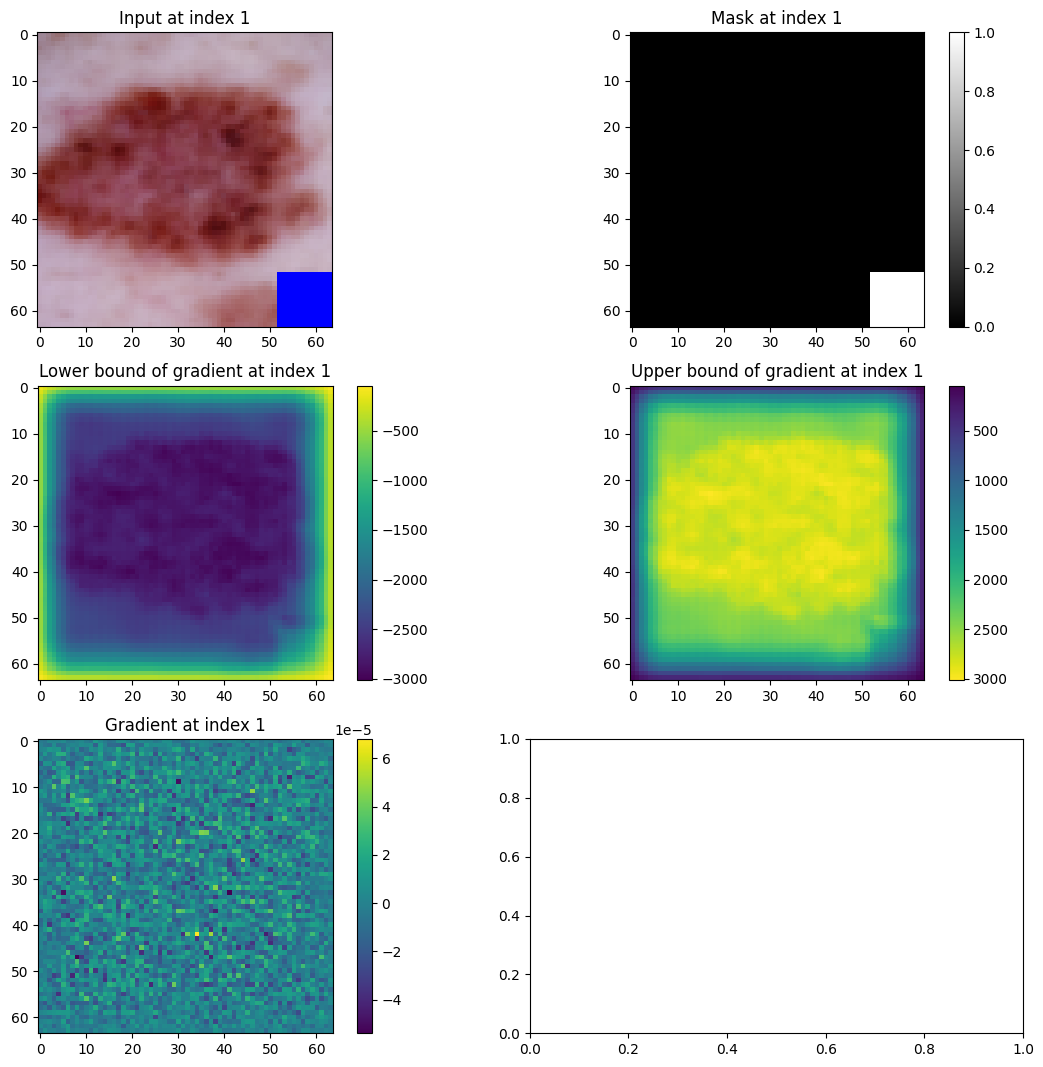

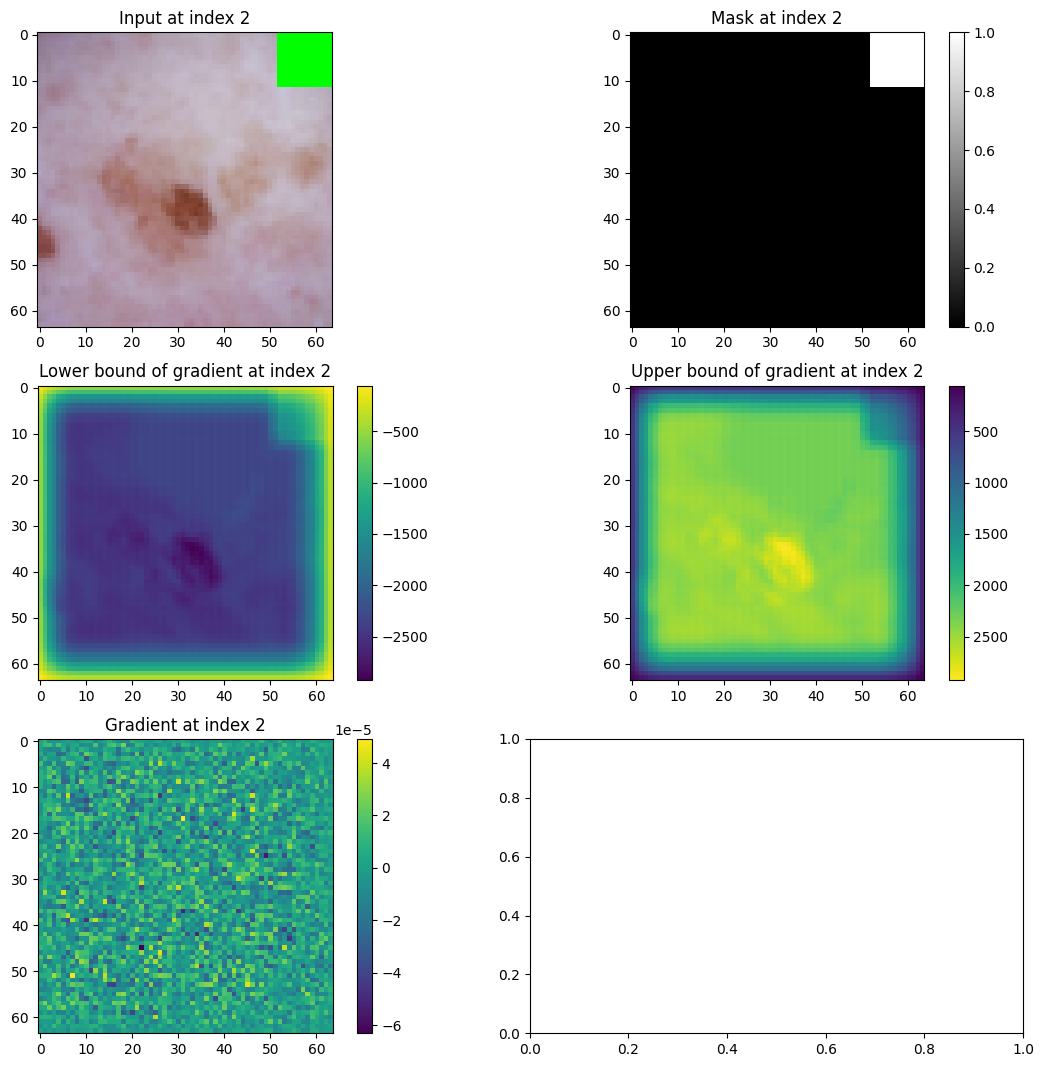

In [7]:
idx_to_visualize = 20

init_batch_train_with_masks = next(iter(dl_train))
first_idx_benign, first_idx_malignant = None, None
for i in range(1, len(dl_train)):
    if init_batch_train_with_masks[1][i] == 1:
        first_idx_malignant = i
    if init_batch_train_with_masks[1][i] == 0:
        first_idx_benign = i
    if first_idx_benign is not None and first_idx_malignant is not None:
        break
print(f"first benign index: {first_idx_benign}, first malignant index: {first_idx_malignant}")
init_batch_test_with_masks = next(iter(dl_test))
visualize_gradient(model, *init_batch_train_with_masks, epsilon, first_idx_benign, True, device)
visualize_gradient(model, *init_batch_train_with_masks, epsilon, first_idx_malignant, True, device)
# visualize_gradient(model, *init_batch_test_with_masks, epsilon, idx_to_visualize, True, device)

## Experiments 

In [8]:
DELTA_INPUT_ROBUSTNESS_PARAM = 1

### Standard Training

In [ ]:
std_method = "std"
# Hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_coeff = 20, 1e-4, 4, 0.1, 0.2, -1
# k is a coefficient for the regularization term
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)
    print(f"========== Training model with method {std_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device, True)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                                 "binary_cross_entropy", device, has_conv=True)
    num_robust += num_robust
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    # if i == restarts - 1:
    #     visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize, has_conv=True, curr_device=device)
write_results_to_file("experiment_results/derma_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, std_method)
write_results_to_file("experiment_results/derma_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, std_method)

### RRR Training

In [ ]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
rrr_method = "r3"
# hyperparams
num_epochs, lr, restarts, epsilon, weight_coeff, k = 10, 1e-4, 4, 0.01, 5e-4, 2e-2
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)

    print(f"========== Training model with method {rrr_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, rrr_method,
        k, device, True, k_schedule=uniformize_magnitudes_schedule, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
write_results_to_file("experiment_results/derma_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, rrr_method)
write_results_to_file("experiment_results/derma_mnist_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, rrr_method)

### R4 Training

In [ ]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
num_epochs, lr, restarts, epsilon, weight_coeff, k = 12, 1e-4, 4, 0.01, -1, 0.05
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)

    print(f"========== Training model with method {r4_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, r4_method, k, device, True)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
write_results_to_file("experiment_results/derma_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, r4_method)
write_results_to_file("experiment_results/derma_mnist_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, r4_method)

### IBP_EX Training

In [12]:
ibp_ex_method = "ibp_ex"
# hyperparams
num_epochs, lr, restarts, epsilon, weight_coeff, k = 3, 1e-3, 4, 0.01, 1, 1
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)

    print(f"========== Training model with method {ibp_ex_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, ibp_ex_method,
        k, device, True, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
write_results_to_file("experiment_results/derma_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, ibp_ex_method)
write_results_to_file("experiment_results/derma_mnist_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, ibp_ex_method)

========== Training model with method ibp_ex, restart 0 ==========


Epoch: 100%|██████████| 3/3 [00:20<00:00,  6.87s/it, loss=0.00369, reg=tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.33
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 8.12e+03
========== Training model with method ibp_ex, restart 1 ==========


Epoch:   0%|          | 0/3 [00:00<?, ?it/s, loss=33.5, reg=tensor(32.8125, device='cuda:0', grad_fn=<AddBackward0>)]


KeyboardInterrupt: 

### IBP_EX+R3

In [12]:
ibp_ex_and_r3_method = "ibp_ex+r3"
# hyperparams
num_epochs, lr, restarts, epsilon, weight_coeff, k = 11, 2e-4, 4, 0.01, 2e-4, 0.054
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)

    print(f"========== Training model with method {ibp_ex_and_r3_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, ibp_ex_and_r3_method,
        k, device, True, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
write_results_to_file("experiment_results/derma_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, ibp_ex_and_r3_method)
write_results_to_file("experiment_results/derma_mnist_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, ibp_ex_and_r3_method)

========== Training model with method ibp_ex+r3, restart 0 ==========


Epoch:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 100%|██████████| 11/11 [02:42<00:00, 14.77s/it, loss=1.52, reg=tensor(28.1885, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.33
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 2e+03
========== Training model with method ibp_ex+r3, restart 1 ==========


Epoch: 100%|██████████| 11/11 [02:42<00:00, 14.80s/it, loss=1.77, reg=tensor(32.8640, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.67
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 1.55e+03
========== Training model with method ibp_ex+r3, restart 2 ==========


Epoch: 100%|██████████| 11/11 [02:42<00:00, 14.79s/it, loss=1.82, reg=tensor(33.6491, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.67
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 1.48e+03
========== Training model with method ibp_ex+r3, restart 3 ==========


Epoch: 100%|██████████| 11/11 [02:42<00:00, 14.76s/it, loss=1.82, reg=tensor(33.6493, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.33
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 1.47e+03


# Sample Complexity Experiments

In [ ]:
mask_ratios = [0.8, 0.6, 0.4, 0.2]
methods = ["ibp_ex", "ibp_ex+r3", "r3", "r4"]
for method in methods:
    # Load the params
    params_dict = load_params_or_results_from_file("experiment_results/decoy_mnist_params.yaml", method)
    delta_threshold = params_dict["delta_threshold"]
    epsilon = params_dict["epsilon"]
    k = params_dict["k"]
    weight_coeff = params_dict["weight_coeff"]
    num_epochs = params_dict["num_epochs"]
    lr = params_dict["lr"]
    restarts = params_dict["restarts"]
    for mask_ratio in mask_ratios:
        new_dl_train = derma_mnist.remove_masks(mask_ratio, dl_train)
        train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
        for i in range(restarts):
            # Reinitialize the model
            # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
            torch.manual_seed(i + SEED)
            curr_model = DermaNet(3, IMG_SIZE, 1)

            print(f"========== Training model with method {method} restart {i} and mask ratio {mask_ratio} ==========")
            k_schedule = uniformize_magnitudes_schedule if method in ["r3", "ibp_ex", "ibp_ex+r3"] else None
            train_model_with_certified_input_grad(new_dl_train, num_epochs, curr_model, lr, criterion, epsilon, method,
                                                  k, device, True, weight_reg_coeff=weight_coeff, k_schedule=k_schedule)
            train_acc += test_model_accuracy(curr_model, new_dl_train, device, suppress_log=True)
            test_acc += test_model_accuracy(curr_model, dl_test, device, suppress_log=True)
            n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, delta_threshold,
                                                         "binary_cross_entropy", device, has_conv=True, suppress_log=True)
            num_robust += n_r
            min_robust_delta = min(min_robust_delta, min_delta)
            min_lower_bound += m_l
            max_upper_bound += m_u
        write_results_to_file("experiment_results/decoy_mnist_sample_complexity.yaml",
                            {"train_acc": round(train_acc / restarts, 3),
                             "test_acc": round(test_acc / restarts, 3),
                             "num_robust": round(num_robust / restarts, 3),
                             "min_lower_bound_avg": round(min_lower_bound / restarts, 3),
                             "max_upper_bound_avg": round(max_upper_bound / restarts, 3),
                             "min_robust_delta": min_robust_delta}, method + f"_{int(mask_ratio * 100)}")